Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%run "Common setup.ipynb"

In [3]:
RC = mk.RecordCollection("tmp/rest_filtered_corpora.txt")

In [4]:
wos_config = wosis.load_config('config.yml')

<hr> Analysing software packages in the corpora <br>


In [5]:
uc_software_packages = wosis.keyword_matches(RC, ['software', 'toolkit', 'toolbox'], threshold=95.0)

In [6]:
all_uc_software = uc_software_packages.combine_recs()

In [7]:
(wosis.rc_to_df(all_uc_software)).to_csv('../data/software_packages_rest.csv')

    - Keyword trend 
    - Key-phrase analysis

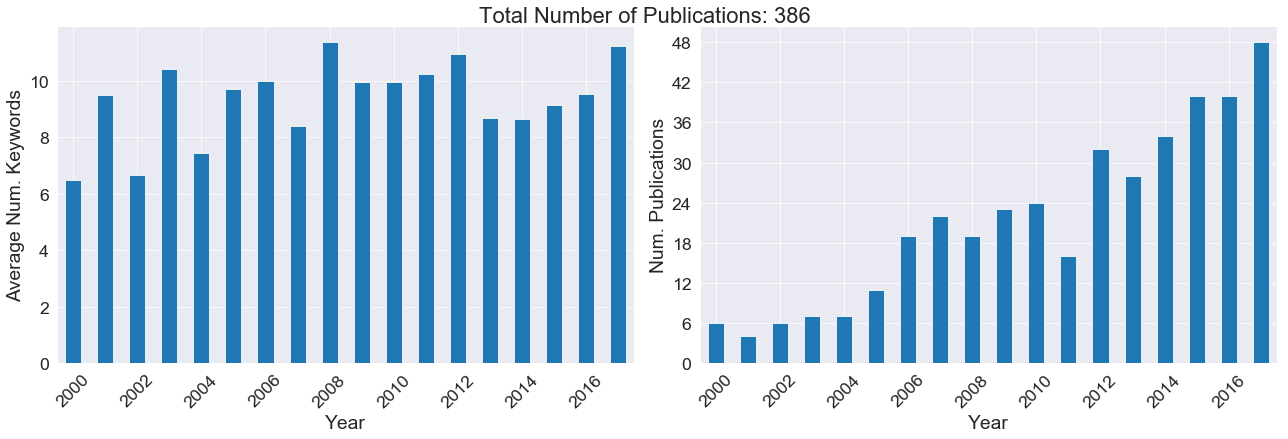

In [8]:
wos_plot.plot_kw_trend(all_uc_software)

In [9]:
software_phrases = wosis.find_phrases(wosis.rc_to_df(all_uc_software))

In [ ]:
# software_phrases.display_phrases()

<hr>
Create a dataframe of relevant papers: manual sorting

In [ ]:
# Export phrase data
software_phrases.all_phrases.to_csv('../data/software_phrases_unfiltered.csv')

We then sort the publications into separate topics

In [10]:
software_RC = wosis.extract_recs(software_phrases.document_ids, RC)

In [11]:
len(software_RC)

386

In [13]:
import pickle

In [15]:
# software_topics = wosis.find_topics(software_RC, num_topics=10)

```python
software_topics = wosis.find_topics(software_RC, num_topics=10)
```

```
Topic 1: model paramet uncertainti use data method analysi simul sensit wa
Topic 2: optim design optimization shape method element structur adjoint algorithm topolog
Topic 3: life product lca impact energi environment cycl cycle wa electr
Topic 4: risk assess ecolog exposur health probabilist multipl hazard uncertainti calcul
Topic 5: water lake groundwat qualiti flux irrig surfac quality dam river
Topic 6: design integr support decis tool process framework develop polici environment
Topic 7: swat soil river model hydrolog calibr catchment watersh runoff flow
Topic 8: crop potato climat yield chang period water demand precipit class
Topic 9: thermal heat build temperatur bridg invers simul flux design energi
Topic 10: flood urban map hazard area event risk wa grid surfac
```

The above results appear to indicate that 

* Topic 1 is related to model uncertainty and sensitivity
* Topic 2 is relevant to optimization studies
* Topic 6 includes model development and design studies

We'll save the topic results to a file so we don't lose this particular result set

```python
with open("tmp/software_topic_results_2019-02-23.pkl", "wb") as fn:
    pickle.dump(software_topics, fn)
```

To load it back in at a later date, we'd run:

```python
with open("tmp/software_topic_results_2019-02-23.pkl", "rb") as fn:
    software_topics = pickle.load(fn)
```

In [14]:
with open("tmp/software_topic_results_2019-02-23.pkl", "rb") as fn:
    software_topics = pickle.load(fn)

In [16]:
topic_ids_of_interest = {
    'uasa': 1,
    'optimization': 2,
    'design': 6,
} 

software_topic_dfs = {k: software_topics.get_topic_by_id(i) for k, i in topic_ids_of_interest.items()}

# Create DOI columns
software_topic_dfs = {k: wosis.link_to_pub(wosis.extract_recs(df.id, software_RC)) for k, df in software_topic_dfs.items()}

In [17]:
for topic_name, df in software_topic_dfs.items():
    print('{}:'.format(topic_name), len(df))
    
print('Total:', sum([len(df) for df in software_topic_dfs.values()]))

uasa: 203
optimization: 35
design: 23
Total: 261


We can then qualitatively look at the above results aided by key phrase extraction

In [18]:
uasa_phrases = wosis.find_phrases(software_topic_dfs['uasa'], weighted_keywords=['software', 'toolkit', 'toolbox', 'package', 'sensitivity', 'uncertainty'])

An unfiltered dataset is exported for transparency followed by a copy that will be manually sorted and modified

In [19]:
uasa_phrases.all_phrases.to_csv('../data/uasa_software_phrases_unsorted.csv')

In [20]:
# uasa_phrases.all_phrases.to_csv('../data/uasa_software_phrases_sorted.csv')

The above dataset is then qualitatively examined to identify papers that either introduces software, code, or applies an existing software package for UA/SA.

Once the manual process is complete, the file `uasa_software_phrases_sorted.csv` is overwritten with an additional column "relevant".

A simple "Yes" and "No" is used to indicate whether the study applied software.

An effort is made to identify the software. Otherwise a simple "Yes" indicates that UA/SA was conducted with some method named, but no software clearly indicated.

In some cases the article was not related to the field of environmental modeling and so is marked with a "No (not related to environment)". Reviews and discussion papers were also marked with "No"

Cases where it was not immediately clear what was done - if UA/SA software was used or if/how it was conducted - are marked with a '?' (some papers may simply state something to the effect of 'sensitivity analysis was applied').


In [21]:
sorted_software = pd.read_csv('../data/uasa_software_phrases_sorted.csv')

In [22]:
is_relevant = sorted_software.relevant.str.contains("Yes") == True
not_relevant = sorted_software.relevant.str.contains("No") == True
unknown_relevance = sorted_software.relevant.str.contains("\?") == True


print("{} papers are relevant".format(len(sorted_software[is_relevant])))
print("{} papers are not relevant".format(len(sorted_software[not_relevant])))
print("{} papers have unknown relevance".format(len(sorted_software[unknown_relevance])))

96 papers are relevant
72 papers are not relevant
33 papers have unknown relevance


In [23]:
relevant_papers = sorted_software[is_relevant]

In [24]:
# We need to remove the year that helpfully gets added to title
title_list = sorted_software[is_relevant].title.tolist()
title_list = [' '.join(t.split(' ')[0:-1]) for t in title_list]

relevant_pubs = wosis.find_pubs_by_title(software_RC, title_list)

In [25]:
pubs = wosis.link_to_pub(wosis.rc_to_df(relevant_pubs))

In [26]:
pubs.loc[:, ~pubs.columns.isin(hide_columns)].to_csv('../data/relevant_UASA_software_papers.csv')